# Graffiti complaints
## --- as a  social indicator in New York City

Author: Jianwei Li 

Github Link: https://github.com/jianweili0/PUI2018_jl9200/blob/master/EC_Project/EC_jl9200_GraffitiProject.ipynb

**Abstract**

A data science project to investigate the social factors about Graffiti Complaints from 311 service request calls in New York City  to test its social relationship  based on some selected social factors from the local media, such as  education level,     unemployment rate,      and crime rate (relate to Burglary  and Theft).  The article will also examine how the date of Graffiti complaint call and its cleaning duration change over time, and try to predict the cleaning duration based on a time series analysis.


**Problem Description: **

Graffiti is one of the street-art expression forms of drawing, writing and even scripting. It is typically illegal because of it always companion with violation of property or action without consent. In New York City, you might encounter different genres of Graffiti, such as Hip-hop, Gangster, Politic and etc., which some of them are featured on social media on Instagram or Facebook. While the visitors are enjoying the vibe of street-art and shop owners are infuriating about those painting in front of their properties, the New York City did initiate a Graffiti Free NYC Program back into 1999, to provide free graffiti removal per requests from 311 calls. 

Based on the data I from NYPD graffiti complaints and 311 complaints about graffiti. I would like to see how its’ spatial trend over the year of 2015 to 2016, and its possible spatial correlation with income level and the crime rate. The idea is to plot the graffiti density as a heat map and overlay with the incidents’ location of five most frequent crime types in New York. Based on “ [__Broken Windows Theory__](https://en.wikipedia.org/wiki/Broken_windows_theory),” I will expect that the higher density of graffiti in the neighborhood will are positive relate to a higher crime rate, a higher young unemployment rate, and lower education level.



**Problem Motivation: **

There is an article, [__De Blasio Administration Not Pleased With Report Saying Anti-Graffiti Efforts Are Too Slow__](https://newyork.cbslocal.com/2016/09/08/de-blasio-anti-graffiti/),  from CBS New York in Dec 2016, mentioned that the average response time between complaint and cleanup grew from 67 days in 2013 to 114 days in 2016. However, the director from the Graffiti-Free NYC, Anthony Hogrebe, argued that the teams had cleaned up 6 million square feet in 2016 compared to 4.3 million in 2014. He also blamed that the increase of the response times is the graffitis at those difficult-to-reach places. In this case, I would imagine using 311 graffiti complaints as a proxy to build a model to predict the graffiti density of NYC, which ideally could help the Graffiti-Free NYC outreach team to deploy better strategies in different neighborhoods and reduce the cleaning response time.

# Data


1.Puma data link:https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile

2.Graffiti data link: https://data.cityofnewyork.us/Social-Services/Graffiti-311-coimplaints/86yu-rdbf?defaultRender=richList

3.Crime data link by NYPD complaint: https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243/data

4.311 data: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9
(look into the total number of the complaints, in order to calculate the fraction)


5.Eduction Level(born in state with Bachelor Degree), Total Population (2016),Unemployment Rate of Female age of 16-64, Unemployment Rate of Male age of 16-64 and Total Unemployment rate of age over 16

6.I use Census API key to query the data from ACS census data 2012-2016 5yr https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_5YR_S1501&prodType=table

# Idea or Thought
1. I guess the more graffiti are spotted in the neighborhood, the lower education level and higher unemployment rate and higher crime complaints(what types are not specificed yet)
2. Also, We realize the duration of the graffiti process time is increase over the pass years. I am wondering if there are a seasonal trend for the cleaning duration

#### 1.  Download Graffiti data from 311 complaints request from 2010 to now

In [32]:

import numpy as np
import pandas as pd
import urllib
import requests
import geopandas as gpd
import shapely
import seaborn  as sns
import fiona
from fiona.crs import from_epsg
import os
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
os.system("mkdir data")

0

In [3]:
datadir = os.getcwd()+"/data";datadir

'/nfshome/jl9200/PUI2018_jl9200/EC_Project/data'

#### 1. Download Graffiti data from 311 Graffiti Complaints and All 311 Complaints data

In [4]:
## download the graffiti data from NYPD
url = "https://data.cityofnewyork.us/api/views/86yu-rdbf/rows.csv?accessType=DOWNLOAD"
filename = 'graffiti311.csv'
urllib.request.urlretrieve(url,filename)
graf = pd.read_csv(filename)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
graf.shape

(147511, 38)

In [6]:
# why graf.dropna(['LATITUDE','LONGITUDE'],axis = 1, inplace = True) not working
graf = graf[(~np.isnan(graf.Latitude))&(~np.isnan(graf.Longitude))]
graf = graf[(graf.Latitude!=0)&(graf.Longitude!=0)]

In [7]:
graf.isnull().sum()

Unique Key                             0
Created Date                           0
Closed Date                        17049
Agency                                 0
Agency Name                            0
Complaint Type                         0
Descriptor                             0
Location Type                      16946
Incident Zip                           1
Incident Address                     215
Street Name                          215
Cross Street 1                     59863
Cross Street 2                     59857
Intersection Street 1             142441
Intersection Street 2             142441
Address Type                           0
City                                   0
Landmark                          142654
Facility Type                     140956
Status                                 0
Due Date                           63623
Resolution Action Updated Date         0
Community Board                        0
Borough                                0
X Coordinate (St

* Notice that there are 17049 Nan value in Closed Date 

In [8]:
graf.shape

(142655, 38)

** _trying to understand for the data collection process_**

In [9]:
# Transfer Create Date using pd.to_datetime

In [9]:
graf['startdate'] = pd.to_datetime(graf['Created Date'])

In [11]:
graf['year'] = graf['startdate'].dt.year
graf['month'] = graf['startdate'].dt.month
graf['day'] = graf['startdate'].dt.day

In [12]:
graf.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,startdate,year,month,day
0,15636284,01/01/2010 04:39:20 PM,01/01/2010 04:39:20 PM,DSNY,Department of Sanitation,Graffiti,Graffiti,NaN,11215.0,194 12 STREET,...,NaN,NaN,NaN,40.668958,-73.991103,"(40.668958142504884, -73.99110341884311)",2010-01-01 16:39:20,2010,1,1
1,15636303,01/01/2010 05:26:37 PM,06/30/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,10033.0,565 WEST 174 STREET,...,NaN,NaN,NaN,40.844448,-73.936215,"(40.84444801315609, -73.93621512605705)",2010-01-01 17:26:37,2010,1,1


In [13]:
grafCloseNAN = graf[graf['Closed Date'].isnull()]
grafCloseNAN[['year','Unique Key']].groupby('year',as_index = False).count()

,year,Unique Key
0,2010,572
1,2011,1281
2,2012,1742
3,2013,1133
4,2014,1190
5,2015,812
6,2016,632
7,2017,1833
8,2018,7854


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


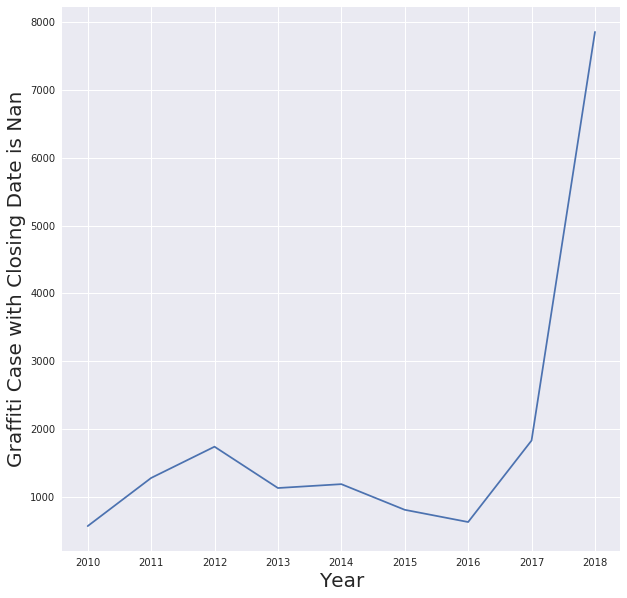

In [30]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(grafCloseNAN[['year','Unique Key']].groupby('year',as_index = False).count()['year'],\
         grafCloseNAN[['year','Unique Key']].groupby('year',as_index = False).count()['Unique Key'])
ax.set_ylabel('Graffiti Case with Closing Date is Nan',fontsize = 20)
ax.set_xlabel('Year',fontsize = 20)
plt.show()

** Figure 1: We can see the in 2017 and 2018, the graffiti Cases with Nan in Closing data is rocketing.  But It decrease from after the De Blasio Administration start his term in 2014. However, we need to zoom into the dataset for more details**

In [15]:
# let's look into the Graffiti Case with the closing data
# graf= graf[~graf['Closed Date'].isnull()]

In [15]:
graf[['year','Unique Key']].groupby('year',as_index = False).count()

,year,Unique Key
0,2010,20334
1,2011,15855
2,2012,15441
3,2013,12942
4,2014,15533
5,2015,13222
6,2016,12296
7,2017,18608
8,2018,18424


In [17]:
# make lon and lat as float

In [16]:
graf['lonlat'] = list(zip(graf['Longitude'],graf['Latitude']))
graf['geometry'] = graf[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))
graf = gpd.GeoDataFrame(graf)

In [20]:
# select the data for 2017 

In [132]:
graf2017 = graf[graf['year']==2017]

In [133]:
graf2017.crs =from_epsg(4326)

In [134]:
graf2017.crs

{'init': 'epsg:4326', 'no_defs': True}

In [135]:
graf2017 = graf2017.to_crs(epsg = 2263)

In [136]:
graf.shape,graf2017.shape

((142655, 44), (18608, 44))

download all 311 complaints data and extra only the data in year 2017 

In [70]:
# it take a long time to run, so I decide to export it locally
url = 'https://data.cityofnewyork.us/api/views/erm2-nwe9/rows.csv?accessType=DOWNLOAD'
# filename = '311.csv'
# urllib.request.urlretrieve(url,filename)
data311 = pd.read_csv(url,usecols = ['Latitude', 'Longitude', 'Complaint Type','Created Date'], dtype = {'Complaint Type': str })

In [73]:
data311.to_csv('full311.csv',index = False)

In [74]:
data311.head()

,Created Date,Complaint Type,Latitude,Longitude
0,12/08/2010 12:00:00 AM,GENERAL CONSTRUCTION,40.887354,-73.912142
1,12/08/2010 12:00:00 AM,GENERAL CONSTRUCTION,40.833606,-73.918558
2,12/08/2010 12:00:00 AM,GENERAL CONSTRUCTION,40.800261,-73.954700
3,12/08/2010 12:00:00 AM,GENERAL CONSTRUCTION,40.854638,-73.900100
4,12/08/2010 12:00:00 AM,GENERAL CONSTRUCTION,40.573588,-73.992855


In [85]:
data311.shape

(17534248, 4)

In [86]:
data311 = data311[(data311.Latitude!=0)&(data311.Longitude!=0)]

In [87]:
data311 = data311[(~np.isnan(data311.Latitude))&(~np.isnan(data311.Longitude))]

In [90]:
data311.shape

(17534248, 5)

In [89]:
# it take a long time to run
data311['date']= pd.to_datetime(data311['Created Date'])

In [91]:
data311['year'] = data311['date'].dt.year
data311['month']=data311['date'].dt.month
data311['day'] = data311['date'].dt.day

In [93]:
data311.head()

,Created Date,Complaint Type,Latitude,Longitude,date,year,month,day
0,12/08/2010 12:00:00 AM,GENERAL CONSTRUCTION,40.887354,-73.912142,2010-12-08,2010,12,8
1,12/08/2010 12:00:00 AM,GENERAL CONSTRUCTION,40.833606,-73.918558,2010-12-08,2010,12,8
2,12/08/2010 12:00:00 AM,GENERAL CONSTRUCTION,40.800261,-73.954700,2010-12-08,2010,12,8
3,12/08/2010 12:00:00 AM,GENERAL CONSTRUCTION,40.854638,-73.900100,2010-12-08,2010,12,8
4,12/08/2010 12:00:00 AM,GENERAL CONSTRUCTION,40.573588,-73.992855,2010-12-08,2010,12,8


In [214]:
data311_2017 = data311[data311['year']==2017]

In [215]:
data311_2017.shape

(2269939, 8)

#### 2. Download PUMA DATA

In [124]:
#### Download the PUMA DATA
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=GeoJSON"
filename = 'puma.geojson'
urllib.request.urlretrieve(url,filename)

('puma.geojson', <http.client.HTTPMessage at 0x7fce33d0e748>)

In [125]:
pumadata = gpd.read_file(filename)

In [126]:
!ls

311.csv       EC_jl9200_GraffitiProject.ipynb  graffiti311.csv	__pycache__
censusAPI.py  full311.csv		       puma.geojson	README.md


In [115]:
pumadata = pumadata.to_crs(epsg = 2263)

In [116]:
pumadata.crs

{'init': 'epsg:2263', 'no_defs': True}

In [117]:
graf2017['Location Type'] = graf2017['Location Type'].astype('str')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


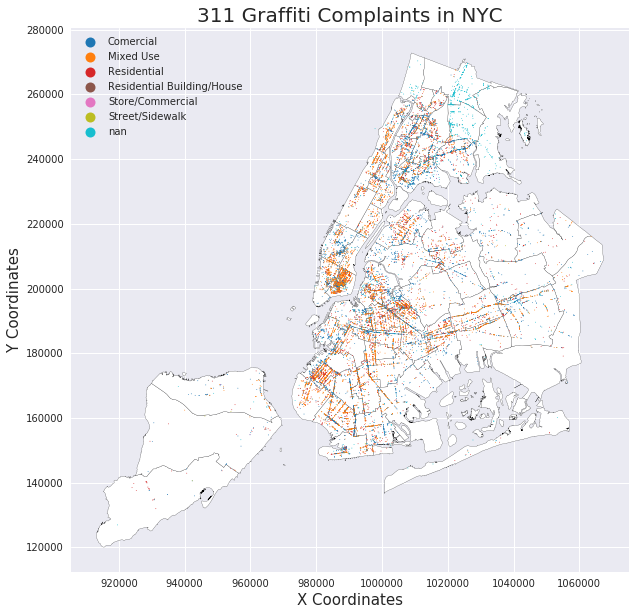

In [31]:
# first plot!
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

pumadata.plot(ax = ax, color = "white",edgecolor = "black",lw = 0.2)
graf2017.plot(ax = ax,markersize = 0.2,column = 'Location Type',legend = True)
ax.set_title('311 Graffiti Complaints in NYC',fontsize = 20)
ax.set_xlabel('X Coordinates',fontsize=15)
ax.set_ylabel('Y Coordinates',fontsize=15)
ax.legend()

** Figure 2: This is the 311 Graffiti Complaints in 2017 in NYC with the legends indicate the location types**

#### 3. Download Unemployment data from Census API

In [137]:
import json
# look into the ACS 5yr data
# download 5 year census data 
url = "https://api.census.gov/data/2015/acs/acs5/variables.json"
resp = requests.request('GET',url)
aff5 = json.loads(resp.text)

In [138]:
aff5keys = list(aff5['variables'].keys())

In [139]:
len(aff5keys)

22807

In [140]:
aff5

{'variables': {'B24011_006E': {'attributes': 'B24011_006M,B24011_006MA,B24011_006EA',
   'concept': 'OCCUPATION BY MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER',
   'group': 'B24011',
   'label': 'Estimate!!Total!!Management, business, science, and arts occupations!!Computer, engineering, and science occupations',
   'limit': 0,
   'predicateType': 'int'},
  'B24122_349E': {'attributes': 'B24122_349M,B24122_349MA,B24122_349EA',
   'concept': 'DETAILED OCCUPATION BY MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) FOR THE FULL-TIME, YEAR-ROUND CIVILIAN EMPLOYED MALE POPULATION 16 YEARS AND OVER',
   'group': 'B24122',
   'label': 'Estimate!!Total!!Electricians',
   'limit': 0,
   'predicateType': 'int'},
  'B17001B_051E': {'attributes': 'B17001B_051M,B17001B_051MA,B17001B_051EA',
   'concept': 'POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE)

Based on the json file I search the Umemployed and Find out the key start with "C23002"

Check the Census Reporter (for each "C23002")  https://censusreporter.org/tables/C23002A/

** Thus I will use Table C23002G: Sex by Age by Employment Status (Two or More Races) **

In [141]:
aff5['variables']['C23002G_001E']['label']

'Estimate!!Total'

In [142]:
[(k,aff5['variables'][k]['label']) for k in aff5keys if k.startswith("C23002G")\
and 'Unemployed' in aff5['variables'][k]['label']]

[('C23002G_021E',
  'Estimate!!Total!!Female!!16 to 64 years!!In labor force!!Civilian!!Unemployed'),
 ('C23002G_008E',
  'Estimate!!Total!!Male!!16 to 64 years!!In labor force!!Civilian!!Unemployed'),
 ('C23002G_013E',
  'Estimate!!Total!!Male!!65 years and over!!In labor force!!Unemployed'),
 ('C23002G_026E',
  'Estimate!!Total!!Female!!65 years and over!!In labor force!!Unemployed')]

** I choose Male and Female Unemployed in 16 to 64 years **
** and I also need the sum of total Unemployment rate in 16 to 64 years **

In [143]:
UnemployedMkey = 'C23002G_008E'
UnemployedFkey = 'C23002G_021E'
Totpopkey = 'C23002G_001E'
AllPopkey = 'B00001_001E'
EduKey = 'B06009_011E' # Born in state of residence!!Bachelor's degree 

In [173]:
from censusAPI import myAPI  # remember to delete 
import io


In [174]:
url = "https://api.census.gov/data/2015/acs/acs5?get="+EduKey+\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI

res = requests.request('GET',url)
Edu = pd.read_csv(io.StringIO(res.content.decode('utf-8').replace('[','').replace(']','')))
Edu = Edu.drop(['NAME','state','Unnamed: 4'],axis = 1)
Edu.columns = ['Edu','puma']
Edu.head(2)

,Edu,puma
0,5650,100
1,9619,200


In [175]:
url = "https://api.census.gov/data/2015/acs/acs5?get="+AllPopkey+\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI

res = requests.request('GET',url)
AllPop = pd.read_csv(io.StringIO(res.content.decode('utf-8').replace('[','').replace(']','')))
AllPop = AllPop.drop(['NAME','state','Unnamed: 4'],axis = 1)
AllPop.columns = ['Apop','puma']
AllPop.head(2)

,Apop,puma
0,15725,100
1,23140,200


In [176]:
url = "https://api.census.gov/data/2015/acs/acs5?get="+UnemployedMkey+\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
res = requests.request('GET',url)
unemployedM = pd.read_csv(io.StringIO(res.content.decode('utf-8').replace("[","").replace("]","")))
unemployedM = unemployedM.drop(['NAME','state','Unnamed: 4'],axis = 1)
unemployedM.columns = ['unemployedM','puma']
unemployedM.head(2)

,unemployedM,puma
0,75,100
1,141,200


In [177]:
url = "https://api.census.gov/data/2015/acs/acs5?get="+UnemployedFkey+\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
res = requests.request('GET',url)
unemployedF = pd.read_csv(io.StringIO(res.content.decode('utf-8').replace("[","").replace("]","")))
unemployedF = unemployedF.drop(['NAME','state','Unnamed: 4'],axis = 1)
unemployedF.columns = ['unemployedF','puma']
unemployedF.head(2)

,unemployedF,puma
0,79,100
1,74,200


In [178]:
url = "https://api.census.gov/data/2015/acs/acs5?get="+Totpopkey+\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
res = requests.request('GET',url)
Totpop = pd.read_csv(io.StringIO(res.content.decode('utf-8').replace("[","").replace("]","")))
Totpop = Totpop.drop(['NAME','state','Unnamed: 4'],axis = 1)
Totpop.columns = ['UnemployedPop','puma']
Totpop.head()

,UnemployedPop,puma
0,1304,100
1,1782,200
2,1066,300
3,724,401
4,2476,402


In [179]:
totcount['puma'] = totcount['puma'].astype(int)
totcount.head()

,puma,Complaint Type
0,3701,31550
1,3702,42438
2,3703,23348
3,3704,36930
4,3705,54473


** Merge all the unemployment data together and calculate the total unemployment rate for male female and total **

In [180]:
Unemployment = AllPop.merge(Totpop).merge(unemployedF).merge(unemployedM).merge(Edu)


In [181]:
Unemployment.head(2)

,Apop,puma,UnemployedPop,unemployedF,unemployedM,Edu
0,15725,100,1304,79,75,5650
1,23140,200,1782,74,141,9619


#### 4. Download Crime data from New York City Police Department (NYPD)

In [182]:
url = "https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD"
crime = pd.read_csv(url)

In [183]:
crime = crime.drop('Lat_Lon',axis = 1)

In [184]:
crime = crime[(~np.isnan(crime['Latitude']))&(~np.isnan(crime['Longitude']))]

In [185]:
crime = crime.dropna(subset=['OFNS_DESC'])

In [186]:
crime.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,457872064,113,QUEENS,06/30/2018,23:30:00,06/30/2018,23:40:00,COMPLETED,NaN,NaN,...,BLACK,M,NaN,18-24,BLACK,F,1048111.0,188479.0,40.683786,-73.769746
1,271939965,115,QUEENS,06/30/2018,23:20:00,06/30/2018,23:25:00,COMPLETED,NaN,NaN,...,WHITE HISPANIC,M,NaN,18-24,ASIAN/PAC.ISL,M,1017940.0,214837.0,40.756298,-73.878397
2,862644726,94,BROOKLYN,06/30/2018,23:09:00,06/30/2018,23:25:00,COMPLETED,NaN,NaN,...,BLACK,M,NaN,45-64,ASIAN/PAC.ISL,M,997245.0,204130.0,40.726965,-73.953117
3,354814756,41,BRONX,06/30/2018,23:00:00,06/30/2018,23:19:00,COMPLETED,NaN,NaN,...,BLACK,M,NaN,UNKNOWN,UNKNOWN,E,1012522.0,239685.0,40.824519,-73.897849
4,963900505,43,BRONX,06/30/2018,23:00:00,06/30/2018,23:29:00,COMPLETED,MONROE,911.0,...,WHITE HISPANIC,M,NaN,18-24,WHITE HISPANIC,F,1021060.0,238980.0,40.822552,-73.867003


In [187]:
crime.columns

Index(['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
       'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT',
       'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD',
       'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD',
       'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude',
       'Longitude'],
      dtype='object')

In [188]:
crime.isnull().sum()

CMPLNT_NUM                0
ADDR_PCT_CD               0
BORO_NM                 150
CMPLNT_FR_DT              0
CMPLNT_FR_TM              0
CMPLNT_TO_DT          33581
CMPLNT_TO_TM          33452
CRM_ATPT_CPTD_CD          0
HADEVELOPT           217227
HOUSING_PSA          211212
JURISDICTION_CODE       148
JURIS_DESC                0
KY_CD                     0
LAW_CAT_CD                0
LOC_OF_OCCUR_DESC     41592
OFNS_DESC                 0
PARKS_NM             227192
PATROL_BORO             148
PD_CD                   148
PD_DESC                 148
PREM_TYP_DESC           987
RPT_DT                    0
STATION_NAME         222833
SUSP_AGE_GROUP        58222
SUSP_RACE             58210
SUSP_SEX              58210
TRANSIT_DISTRICT     222833
VIC_AGE_GROUP             0
VIC_RACE                  0
VIC_SEX                   0
X_COORD_CD                0
Y_COORD_CD                0
Latitude                  0
Longitude                 0
dtype: int64

In [189]:
len(crime['OFNS_DESC'].unique())

57

** For the Crime data, I select those related to Burglary and Theft **

In [190]:
selCrimeTypes = ["BURGLAR'S TOOLS","BURGLARY","GRAND LARCENY","GRAND LARCENY OF MOTOR VEHICLE",\
                 "PETIT LARCENY","POSSESSION OF STOLEN PROPERTY","ROBBERY"]

In [192]:
crime[['OFNS_DESC','CMPLNT_NUM']].groupby('OFNS_DESC').count()

,CMPLNT_NUM
OFNS_DESC,
ABORTION,1
ADMINISTRATIVE CODE,479
AGRICULTURE & MRKTS LAW-UNCLASSIFIED,61
ALCOHOLIC BEVERAGE CONTROL LAW,43
ANTICIPATORY OFFENSES,2
ARSON,371
ASSAULT 3 & RELATED OFFENSES,26453
BURGLAR'S TOOLS,159
BURGLARY,5504


In [193]:
# sorted(crime['OFNS_DESC'].unique())

In [194]:
# use df[df['A'].isin(valuelist)]
# reference: https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe

In [195]:
crimedata = crime[crime['OFNS_DESC'].isin(selCrimeTypes)].reset_index()

In [196]:
crimedata.head(2)

,index,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,...,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,7,963520368,42,BRONX,06/30/2018,22:55:00,06/30/2018,22:58:00,COMPLETED,NaN,...,BLACK,M,NaN,18-24,BLACK,F,1012860.0,244801.0,40.838559,-73.896606
1,10,585148547,28,MANHATTAN,06/30/2018,22:50:00,06/30/2018,23:00:00,COMPLETED,NaN,...,BLACK,F,NaN,UNKNOWN,UNKNOWN,D,999002.0,230857.0,40.800321,-73.946719


In [197]:
crimedata.shape

(76875, 35)

In [198]:
crimedata['lonlat'] = list(zip(crimedata['Longitude'],crimedata['Latitude']))
crimedata['geometry'] = crimedata[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))
crimedata = gpd.GeoDataFrame(crimedata)
crimedata.crs = from_epsg(4326)
crimedata=crimedata.to_crs(epsg = 2263)
crimedata.head(2)

,index,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,...,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,lonlat,geometry
0,7,963520368,42,BRONX,06/30/2018,22:55:00,06/30/2018,22:58:00,COMPLETED,NaN,...,NaN,18-24,BLACK,F,1012860.0,244801.0,40.838559,-73.896606,"(-73.896605923, 40.838559364)",POINT (1012859.603194975 244804.0181131161)
1,10,585148547,28,MANHATTAN,06/30/2018,22:50:00,06/30/2018,23:00:00,COMPLETED,NaN,...,NaN,UNKNOWN,UNKNOWN,D,999002.0,230857.0,40.800321,-73.946719,"(-73.946718878, 40.800321033)",POINT (999001.6010110233 230860.0149029614)


In [199]:
# Also I select a subset of 2017 crimedata to compare the 2017 crimedata

In [200]:
crimedata['year'] = [int(crimedata['CMPLNT_FR_DT'][i].split('/')[-1]) for i in range(len(crimedata['CMPLNT_FR_DT']))]

In [201]:
crime2017 = crimedata[crimedata['year']==2017]

#### 5.Data Wrangling

** _Try to spatial join the graffiti spot on the censustract_ **

In [202]:
pumadata.head(1)

,puma,shape_area,shape_leng,geometry
0,3701,97928517.7258,53227.1444612,(POLYGON ((-73.89641133483133 40.9045045208202...


In [203]:
graf.head(1)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Segment,Latitude,Longitude,Location,startdate,year,month,day,lonlat,geometry
0,15636284,01/01/2010 04:39:20 PM,01/01/2010 04:39:20 PM,DSNY,Department of Sanitation,Graffiti,Graffiti,NaN,11215.0,194 12 STREET,...,NaN,40.668958,-73.991103,"(40.668958142504884, -73.99110341884311)",2010-01-01 16:39:20,2010,1,1,"(-73.9911034188, 40.6689581425)",POINT (-73.99110341884311 40.66895814250488)


In [204]:
graf2017.crs

{'init': 'epsg:2263', 'no_defs': True}

In [205]:
pumadata.crs

{'init': 'epsg:4326'}

In [207]:
pumadata = pumadata.to_crs(epsg=2263)

In [208]:
grafjoin = gpd.sjoin(graf2017,pumadata,op='within')

In [210]:
grafjoin.shape

(18605, 48)

In [73]:
grafjoin.head(1)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,startdate,year,month,day,lonlat,geometry,index_right,puma,shape_area,shape_leng
90055,35813619,03/28/2017 09:41:27 AM,05/22/2017 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Residential,10468.0,2761 UNIVERSITY AVENUE,...,2017-03-28 09:41:27,2017,3,28,"(-73.8995994734, 40.8703484128)",POINT (1012017.999983449 256385.0144381144),0,3701,97928517.7258,53227.1444612


In [211]:
grafcount = grafjoin[['index_right','puma']].groupby('puma',as_index = False).count()
grafcount.columns = ['puma','grafCount']

In [212]:
grafcount.head()

,puma,grafCount
0,3701,96
1,3702,220
2,3703,66
3,3704,211
4,3705,539


In [216]:
data311_2017.head()

,Created Date,Complaint Type,Latitude,Longitude,date,year,month,day
34,10/04/2017 01:34:41 PM,UNSANITARY CONDITION,40.872372,-73.885582,2017-10-04 13:34:41,2017,10,4
109,10/04/2017 03:52:06 PM,UNSANITARY CONDITION,40.703387,-73.781192,2017-10-04 15:52:06,2017,10,4
158,10/04/2017 10:29:00 AM,Street Light Condition,40.760512,-73.829133,2017-10-04 10:29:00,2017,10,4
175,10/04/2017 10:26:00 AM,Street Light Condition,40.760512,-73.829133,2017-10-04 10:26:00,2017,10,4
229,10/04/2017 11:43:04 AM,PLUMBING,40.866116,-73.892845,2017-10-04 11:43:04,2017,10,4


In [217]:
# create geometry using lonlat

data311_2017['lonlat'] = list(zip(data311_2017['Longitude'],data311_2017['Latitude']))
data311_2017['geometry'] = data311_2017[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
data311_2017 = gpd.GeoDataFrame(data311_2017)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [218]:
data311_2017.crs=from_epsg(4326)
data311_2017 = data311_2017.to_crs(epsg=2263)

In [219]:
data311_2017.head()

,Created Date,Complaint Type,Latitude,Longitude,date,year,month,day,lonlat,geometry
34,10/04/2017 01:34:41 PM,UNSANITARY CONDITION,40.872372,-73.885582,2017-10-04 13:34:41,2017,10,4,"(-73.8855815631, 40.8723719294)",POINT (1015893.999981141 257127.014438571)
109,10/04/2017 03:52:06 PM,UNSANITARY CONDITION,40.703387,-73.781192,2017-10-04 15:52:06,2017,10,4,"(-73.7811924262, 40.7033867792)",POINT (1044917.999964034 195615.0143993751)
158,10/04/2017 10:29:00 AM,Street Light Condition,40.760512,-73.829133,2017-10-04 10:29:00,2017,10,4,"(-73.8291333947, 40.7605122716)",POINT (1031584.999971887 216398.0144127812)
175,10/04/2017 10:26:00 AM,Street Light Condition,40.760512,-73.829133,2017-10-04 10:26:00,2017,10,4,"(-73.8291333947, 40.7605122716)",POINT (1031584.999971887 216398.0144127812)
229,10/04/2017 11:43:04 AM,PLUMBING,40.866116,-73.892845,2017-10-04 11:43:04,2017,10,4,"(-73.8928449479, 40.8661155044)",POINT (1013887.999982342 254845.0144371431)


In [104]:
# also sjoin with the puma boundaries
data311join = gpd.sjoin(data311_2017,pumadata,op = 'within')

#### 6.Visualization

In [353]:
# reference: http://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434
from scipy import ndimage
def heatmap(d, bins=(100,100),smoothing = 1.5,cmap = 'jet'):
    def getx(pt):
        return pt.coords[0][0]
    def gety(pt):
        return pt.coords[0][1]
    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap='OrRd', extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()



/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


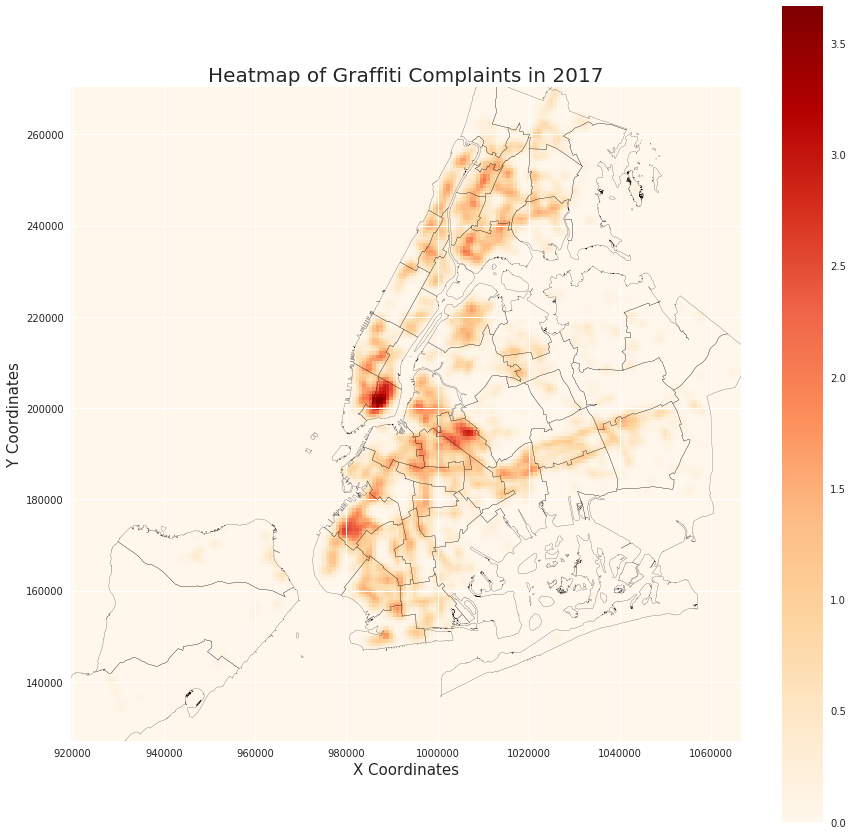

In [357]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
ax.set_title('Heatmap of Graffiti Complaints in 2017',fontsize = 20)
ax.set_xlabel('X Coordinates',fontsize= 15)
ax.set_ylabel('Y Coordinates',fontsize= 15)
pumadata.plot(ax = ax, color = "None",edgecolor = "black",lw = 0.2)
heatmap(graf2017,bins=200,smoothing=1)





** Figure 3-1: 
This heatmap show the density of 311 Graffiti Counts in 2017, The red represent the highest concentration of the graffiti complaints number.**

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


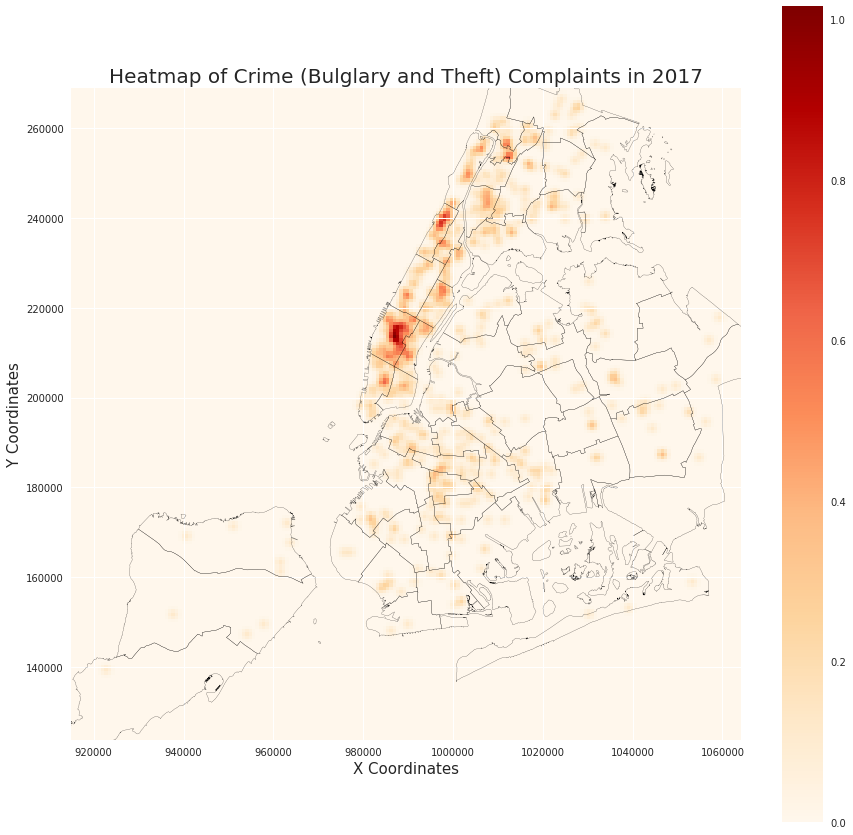

In [359]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
ax.set_title('Heatmap of Crime (Bulglary and Theft) Complaints in 2017',fontsize = 20)
ax.set_xlabel('X Coordinates',fontsize= 15)
ax.set_ylabel('Y Coordinates',fontsize= 15)
pumadata.plot(ax = ax, color = "None",edgecolor = "black",lw = 0.2)
heatmap(crime2017,bins=200,smoothing=1)

# ** Figure 3-2: 
This heatmap show the density of 311 Crime data related to Bulgury and Theft in 2017, The red represent the highest concentration of the graffiti complaints number.**

** From the heatmap we can identify similar location is at midtown Manhattan and downtown Brooklyn area **

In [80]:
# Spatial join and DataWrangling

** _Try to spatial join the crime data spot on the pumadata_ **

In [222]:
crimedata.crs

{'init': 'epsg:2263', 'no_defs': True}

In [223]:
crimejoin = gpd.sjoin(crimedata,pumadata,op = 'within')

In [224]:
crimecount = crimejoin[['index','puma']].groupby('puma',as_index = False).count()
crimecount.columns = ['puma','crimeCount']

In [225]:
crimecount.head(2)

,puma,crimeCount
0,3701,832
1,3702,1251


In [226]:
totcount = data311join[['puma','Complaint Type']].groupby('puma',as_index = False)['Complaint Type'].count()

In [228]:
totcount.head(2)

,puma,Complaint Type
0,3701,31550
1,3702,42438


In [229]:
grafcrim = grafcount.merge(totcount).merge(crimecount)

In [230]:
grafcrim.head()

,puma,grafCount,Complaint Type,crimeCount
0,3701,96,31550,832
1,3702,220,42438,1251
2,3703,66,23348,890
3,3704,211,36930,891
4,3705,539,54473,2009


In [231]:
Unemployment['puma'] = Unemployment['puma'].astype(str)

In [232]:
grafcrim['puma'] = grafcrim['puma'].astype(str)

In [233]:
pumashp = pumadata.reset_index()[['puma','geometry']]

In [234]:
df = pumashp.merge(grafcrim).merge(Unemployment).merge(totcount)

In [236]:
df = df.rename(index = str, columns={'Complaint Type':'totCount'})

In [237]:
df.head()

,puma,geometry,grafCount,totCount,crimeCount,Apop,UnemployedPop,unemployedF,unemployedM,Edu
0,3701,(POLYGON ((1012885.033996583 268830.4841918442...,96,31550,832,7548,3240,263,103,6671
1,3702,(POLYGON ((1027331.841796877 256069.2766112776...,220,42438,1251,10313,2684,104,171,5532
2,3703,(POLYGON ((1042822.450195312 243439.8142089319...,66,23348,890,6462,3538,91,142,8470
3,3704,(POLYGON ((1026308.769592285 256767.6972045382...,211,36930,891,10184,3041,165,106,5448
4,4015,(POLYGON ((997086.4570312516 171933.9880370507...,378,46809,878,12580,2235,166,69,7951


In [238]:
df['Apop'].sum()

595196

In [239]:
df.isnull().sum()

puma             0
geometry         0
grafCount        0
totCount         0
crimeCount       0
Apop             0
UnemployedPop    0
unemployedF      0
unemployedM      0
Edu              0
dtype: int64

In [94]:
# copy a dataset so I can devide all other columns except the crafCount  with Apop (Total population from ACS)

In [241]:
df_s.head()

,puma,geometry,grafCount,totCount,crimeCount,Apop,UnemployedPop,unemployedF,unemployedM,Edu
0,3701,(POLYGON ((1012885.033996583 268830.4841918442...,96,31550,832,7548,3240,263,103,6671
1,3702,(POLYGON ((1027331.841796877 256069.2766112776...,220,42438,1251,10313,2684,104,171,5532
2,3703,(POLYGON ((1042822.450195312 243439.8142089319...,66,23348,890,6462,3538,91,142,8470
3,3704,(POLYGON ((1026308.769592285 256767.6972045382...,211,36930,891,10184,3041,165,106,5448
4,4015,(POLYGON ((997086.4570312516 171933.9880370507...,378,46809,878,12580,2235,166,69,7951


* I would like to plot the total Complaints per person per PUMA

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


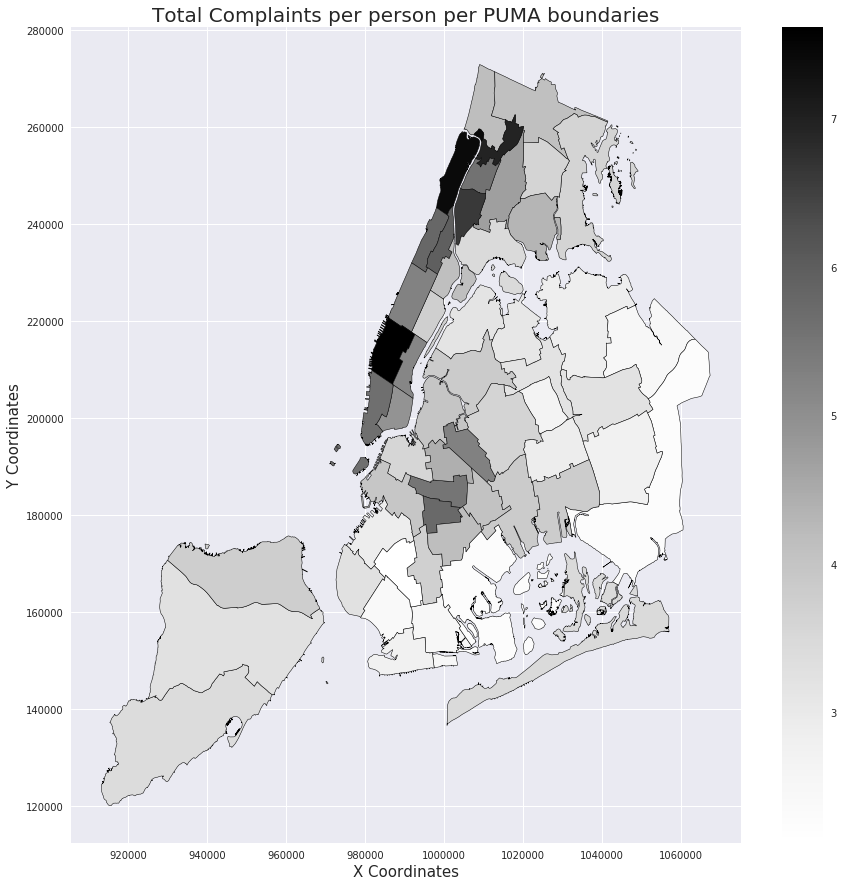

In [252]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
df_s['ComplaintPP'] = df_s['totCount']/df_s['Apop']
df_s.plot(ax = ax,column ='ComplaintPP',legend = True,edgecolor = 'black',lw=0.5)
ax.set_title('Total Complaints per person per PUMA boundaries',fontsize = 20)
ax.set_xlabel('X Coordinates',fontsize = 15)
ax.set_ylabel('Y Coordinates',fontsize = 15)
plt.legend()
plt.show()

* instead of scale the data by divide total population, I believe it will be more porper to scale by total complaints per puma 

In [253]:
df_s['crimeCount'] =df_s['crimeCount']/df_s['totCount']
df_s['unemployedF'] =df_s['unemployedF']/df_s['totCount']
df_s['unemployedM'] =df_s['unemployedM']/df_s['totCount']
df_s['Edu'] =df_s['Edu']/df_s['totCount']
df_s['UnemployedPop'] =df_s['UnemployedPop']/df_s['totCount']

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to 

In [254]:
df.crs

{'init': 'epsg:2263', 'no_defs': True}

In [255]:
df_s.head()

,puma,geometry,grafCount,totCount,crimeCount,Apop,UnemployedPop,unemployedF,unemployedM,Edu,ComplaintPP
0,3701,(POLYGON ((1012885.033996583 268830.4841918442...,96,31550,0.026371,7548,0.102694,0.008336,0.003265,0.211442,4.179915
1,3702,(POLYGON ((1027331.841796877 256069.2766112776...,220,42438,0.029478,10313,0.063245,0.002451,0.004029,0.130355,4.115000
2,3703,(POLYGON ((1042822.450195312 243439.8142089319...,66,23348,0.038119,6462,0.151533,0.003898,0.006082,0.362772,3.613123
3,3704,(POLYGON ((1026308.769592285 256767.6972045382...,211,36930,0.024127,10184,0.082345,0.004468,0.002870,0.147522,3.626277
4,4015,(POLYGON ((997086.4570312516 171933.9880370507...,378,46809,0.018757,12580,0.047747,0.003546,0.001474,0.169860,3.720906


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


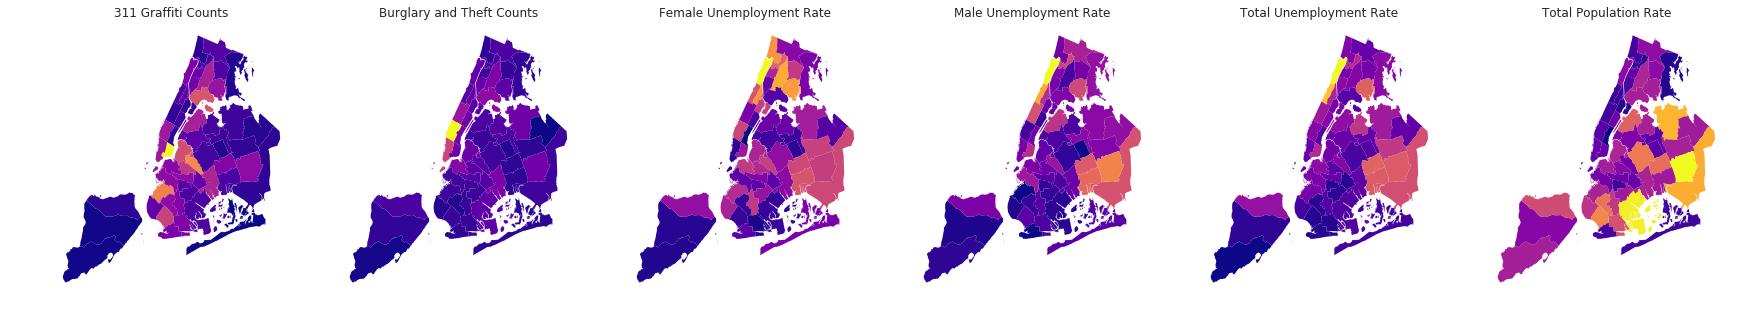

In [256]:
# Trying to plot grafCount, crimeCount, unemployedF,unemployedM and unemployedAll
fig = plt.figure(figsize = (30,5))
ax1 = fig.add_subplot(161)
df.plot(column ='grafCount',ax = ax1,label = True,cmap = 'plasma')
ax1.axis('off')
ax1.set_title(r'311 Graffiti Counts')

ax2 = fig.add_subplot(162)
df.plot(column = 'crimeCount',ax = ax2,label = True,cmap = 'plasma')
ax2.axis('off')
ax2.set_title(r'Burglary and Theft Counts')

ax3 = fig.add_subplot(163)
df.plot(column = 'unemployedF',ax = ax3,label = True,cmap = 'plasma')
ax3.axis('off')
ax3.set_title(r'Female Unemployment Rate')

ax4 = fig.add_subplot(164)
df.plot(column = 'unemployedM',ax = ax4,label = True,cmap = 'plasma')
ax4.axis('off')
ax4.set_title(r'Male Unemployment Rate')


ax5 = fig.add_subplot(165)
df.plot(column = 'UnemployedPop',ax = ax5,label = True,cmap = 'plasma')
ax5.axis('off')
ax5.set_title(r'Total Unemployment Rate')

ax6 = fig.add_subplot(166)
df.plot(column = 'Apop',ax = ax6,label = True,cmap = 'plasma')
ax6.axis('off')
ax6.set_title(r'Total Population Rate')

plt.show()

** Figure 3-3: These plots show the distribution of 311 Graffiti Counts, Crime data about the Buglary Theft, Female and male unemployment Total Unemploymentrate and total populatoin rate. Yellow represent the higest values for each plot. purple to the lowest.**

In [257]:
df.columns

Index(['puma', 'geometry', 'grafCount', 'totCount', 'crimeCount', 'Apop',
       'UnemployedPop', 'unemployedF', 'unemployedM', 'Edu'],
      dtype='object')

#### 7.Analysis

1. I will like to use the Crime Count relate to Bulgury Education level and Unemployment to predict the Number of the GraffitiCount 
2. I will look into the Graffiti cleaning duration over the the pass 8 years to see if there are any seasonal trend

#### Part1

#### Run Ordinal Least Square Model

In [258]:
import statsmodels.api as sm
import scipy.stats

import statsmodels.formula.api as smf

* we try to use the origin model, the model scale by total population, and the model scale by total complaints to decide the best model to proceed further analysis

In [271]:
# scale by totpopulation
df_pop = df[:]
df_pop.columns[3:]
for i in df_pop.columns[3:]:
    if i is not 'Apop':
        df_pop[i] = df_pop[i]/df_pop['Apop']
df_pop.head()

,puma,geometry,grafCount,totCount,crimeCount,Apop,UnemployedPop,unemployedF,unemployedM,Edu
0,3701,(POLYGON ((1012885.033996583 268830.4841918442...,96,4.179915,0.110228,7548,0.429253,0.034844,0.013646,0.883810
1,3702,(POLYGON ((1027331.841796877 256069.2766112776...,220,4.115000,0.121303,10313,0.260254,0.010084,0.016581,0.536410
2,3703,(POLYGON ((1042822.450195312 243439.8142089319...,66,3.613123,0.137728,6462,0.547509,0.014082,0.021975,1.310740
3,3704,(POLYGON ((1026308.769592285 256767.6972045382...,211,3.626277,0.087490,10184,0.298606,0.016202,0.010408,0.534957
4,4015,(POLYGON ((997086.4570312516 171933.9880370507...,378,3.720906,0.069793,12580,0.177663,0.013196,0.005485,0.632035


In [272]:
df_columns = ['crimeCount','Apop','unemployedF','unemployedM','UnemployedPop','Edu']
modOLS = sm.OLS(df.grafCount,sm.add_constant(df.loc[:,df_columns]),missing = 'drop').fit()
print(modOLS.summary())

                            OLS Regression Results                            
Dep. Variable:              grafCount   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.521
Date:                Wed, 19 Dec 2018   Prob (F-statistic):              0.192
Time:                        01:03:44   Log-Likelihood:                -381.71
No. Observations:                  55   AIC:                             777.4
Df Residuals:                      48   BIC:                             791.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const           197.6124    159.221      1.241

In [274]:
df_columns = ['crimeCount','Apop','unemployedF','unemployedM','UnemployedPop','Edu']
modOLS = sm.OLS(df_pop.grafCount,sm.add_constant(df_pop.loc[:,df_columns]),missing = 'drop').fit()
print(modOLS.summary())

                            OLS Regression Results                            
Dep. Variable:              grafCount   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.212
Date:                Wed, 19 Dec 2018   Prob (F-statistic):              0.317
Time:                        01:04:04   Log-Likelihood:                -382.61
No. Observations:                  55   AIC:                             779.2
Df Residuals:                      48   BIC:                             793.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const           273.7893    212.696      1.287

In [275]:
df_columns = ['crimeCount','Apop','unemployedF','unemployedM','UnemployedPop','Edu']
modOLS = sm.OLS(df_s.grafCount,sm.add_constant(df_s.loc[:,df_columns]),missing = 'drop').fit()
print(modOLS.summary())

                            OLS Regression Results                            
Dep. Variable:              grafCount   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1.742
Date:                Wed, 19 Dec 2018   Prob (F-statistic):              0.132
Time:                        01:04:08   Log-Likelihood:                -381.08
No. Observations:                  55   AIC:                             776.2
Df Residuals:                      48   BIC:                             790.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const           255.0755    210.901      1.209

** Interpretation: **

In terms of the propensity of the total complaints, I believe the best model should be the one scale with total complaints
The OLS model show that the crime rate and education's P-values is less than 0.05, but other variable I cannot reject the possibility.

In [276]:
df_s.head()

,puma,geometry,grafCount,totCount,crimeCount,Apop,UnemployedPop,unemployedF,unemployedM,Edu,ComplaintPP
0,3701,(POLYGON ((1012885.033996583 268830.4841918442...,96,31550,0.026371,7548,0.102694,0.008336,0.003265,0.211442,4.179915
1,3702,(POLYGON ((1027331.841796877 256069.2766112776...,220,42438,0.029478,10313,0.063245,0.002451,0.004029,0.130355,4.115000
2,3703,(POLYGON ((1042822.450195312 243439.8142089319...,66,23348,0.038119,6462,0.151533,0.003898,0.006082,0.362772,3.613123
3,3704,(POLYGON ((1026308.769592285 256767.6972045382...,211,36930,0.024127,10184,0.082345,0.004468,0.002870,0.147522,3.626277
4,4015,(POLYGON ((997086.4570312516 171933.9880370507...,378,46809,0.018757,12580,0.047747,0.003546,0.001474,0.169860,3.720906


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


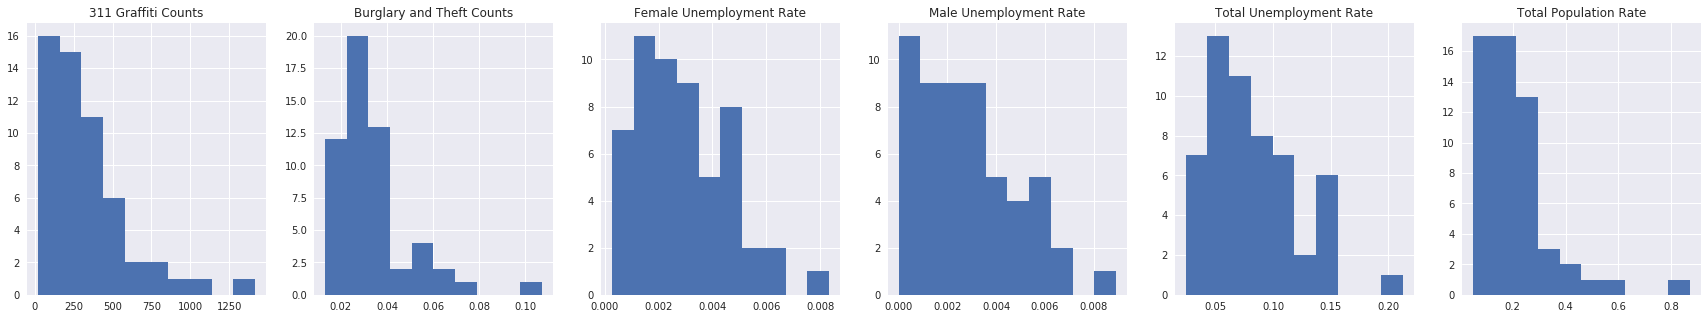

In [277]:
# Trying to plot hist grafCount, crimeCount, unemployedF,unemployedM and unemployedAll
fig = plt.figure(figsize = (30,5))
ax1 = fig.add_subplot(161)
df_s.grafCount.hist(ax = ax1)

ax1.set_title(r'311 Graffiti Counts')

ax2 = fig.add_subplot(162)
df_s.crimeCount.hist(ax = ax2)

ax2.set_title(r'Burglary and Theft Counts')

ax3 = fig.add_subplot(163)
df_s.unemployedF.hist(ax = ax3)

ax3.set_title(r'Female Unemployment Rate')

ax4 = fig.add_subplot(164)
df_s.unemployedM.hist(ax = ax4)

ax4.set_title(r'Male Unemployment Rate')


ax5 = fig.add_subplot(165)
df_s.UnemployedPop.hist(ax = ax5)

ax5.set_title(r'Total Unemployment Rate')

ax6 = fig.add_subplot(166)
df_s.Edu.hist(ax = ax6)

ax6.set_title(r'Total Population Rate')


plt.show()

** Figure 4:These plots show the histogram distribution of 311 Graffiti Counts, Crime data about the Buglary Theft, Female and male unemployment Total Unemploymentrate and total populatoin. From the first glance, it is indistinguishable from Gaussians distribution, Thus we need to try the KS test and pearsonr test. **

**Note** 
I will like to know if these varaibles are Gaussian Distribution 
this can be answered with a KS test, in which case the data has to be standardized, or with an Anderson Darling test.
### KS test
for the Graffiti Count and UnemployedM

In [279]:
df_s.columns

Index(['puma', 'geometry', 'grafCount', 'totCount', 'crimeCount', 'Apop',
       'UnemployedPop', 'unemployedF', 'unemployedM', 'Edu', 'ComplaintPP'],
      dtype='object')

In [281]:
alpha = 0.05

In [282]:
import scipy as sp

print ("For Graffiti Count")
p = sp.stats.kstest((df_s.grafCount - df_s.grafCount.mean())/
                df_s.grafCount.std(), "norm")[1]

if p > alpha:
    print("the Null hypothesis that the samples are drawn from a Gaussian distribution cannot be rejected")
else: 
    print("we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of", alpha)

For Graffiti Count
the Null hypothesis that the samples are drawn from a Gaussian distribution cannot be rejected


In [283]:
print ("For Male Unemployment within 16-65 Fraction")
p = sp.stats.kstest((df_s.unemployedM - df_s.unemployedM.mean())/
                df_s.unemployedM.std(), "norm")[1]

if p > alpha:
    print("the Null hypothesis that the samples are drawn from a Gaussian distribution cannot be rejected")
else: 
    print("we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of", alpha)

For Male Unemployment within 16-65 Fraction
the Null hypothesis that the samples are drawn from a Gaussian distribution cannot be rejected


** Conclusion of KStest**

We cannot see statistical significant differences between these two distribution and the Gaussian distribution.

In [285]:
scipy.stats.pearsonr(df_s.grafCount,df_s.crimeCount)

(0.15342371582471898, 0.26342910671731951)

In [286]:
scipy.stats.pearsonr(df_s.grafCount,df_s.unemployedM)

(-0.081571298212368443, 0.5538225085695041)

In [288]:
scipy.stats.pearsonr(df_s.grafCount,df_s.unemployedF)

(0.0090205948763705246, 0.94788479726625219)

In [289]:
scipy.stats.pearsonr(df_s.grafCount,df_s.UnemployedPop)

(-0.14875437872073333, 0.27841041561375024)

In [290]:
scipy.stats.pearsonr(df_s.grafCount,df_s.Edu)

(-0.29576708809364644, 0.028351114772109522)

** Conclusion ** 

Based on the Pearsonr test, the GrafCount and CrimeCount have a weak positive correlation, but the p-value is higher than 0.05,which mean that we cannot reject the result. Other than that, I see no relation between grafcount with unemployment rate and education.

In [118]:
# Let's also take Total population into account for this model

In [291]:
selcols = df_s.columns[3:];selcols

Index(['totCount', 'crimeCount', 'Apop', 'UnemployedPop', 'unemployedF',
       'unemployedM', 'Edu', 'ComplaintPP'],
      dtype='object')

In [292]:
cols = selcols[0] + ' + '
for i in range(1,len(selcols)):
    cols = cols + selcols[i]
    if i <(len(selcols)-1):
        cols = cols + ' + '
    else:
        continue
formula = 'grafCount~' + cols

In [293]:
formula

'grafCount~totCount + crimeCount + Apop + UnemployedPop + unemployedF + unemployedM + Edu + ComplaintPP'

In [294]:
modOLS_N1 = smf.ols(formula = formula, data = df_s).fit()

In [295]:
print(modOLS_N1.summary())

                            OLS Regression Results                            
Dep. Variable:              grafCount   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1.554
Date:                Wed, 19 Dec 2018   Prob (F-statistic):              0.165
Time:                        01:09:17   Log-Likelihood:                -379.92
No. Observations:                  55   AIC:                             777.8
Df Residuals:                      46   BIC:                             795.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       571.1770    432.703      1.320

In [124]:
# df_columns = ['crimeCount','unemployedF','unemployedM','UnemployedPop','Edu']
# modOLS_N = sm.OLS(df_s.grafCount,sm.add_constant(df_s.loc[:,df_columns]),missing = 'drop').fit()
# print(modOLS_N.summary())

In [296]:
df_s.head()

,puma,geometry,grafCount,totCount,crimeCount,Apop,UnemployedPop,unemployedF,unemployedM,Edu,ComplaintPP
0,3701,(POLYGON ((1012885.033996583 268830.4841918442...,96,31550,0.026371,7548,0.102694,0.008336,0.003265,0.211442,4.179915
1,3702,(POLYGON ((1027331.841796877 256069.2766112776...,220,42438,0.029478,10313,0.063245,0.002451,0.004029,0.130355,4.115000
2,3703,(POLYGON ((1042822.450195312 243439.8142089319...,66,23348,0.038119,6462,0.151533,0.003898,0.006082,0.362772,3.613123
3,3704,(POLYGON ((1026308.769592285 256767.6972045382...,211,36930,0.024127,10184,0.082345,0.004468,0.002870,0.147522,3.626277
4,4015,(POLYGON ((997086.4570312516 171933.9880370507...,378,46809,0.018757,12580,0.047747,0.003546,0.001474,0.169860,3.720906


** Based on the ols test above, I will try to visualize the CrimeCount, UnemployedPop, UnemployedF, UnemployedM **

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


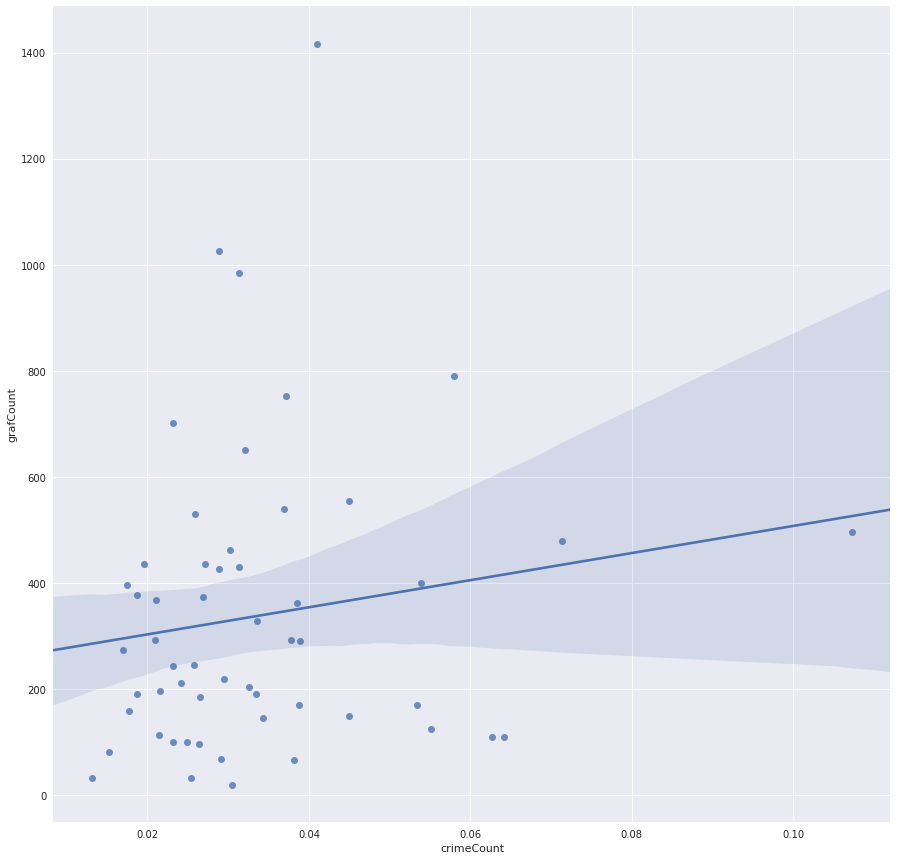

In [298]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)

sns.regplot(x="crimeCount", y="grafCount", data=df_s,ax = ax);

ax.set_ylabel("grafCount")
ax.set_xlabel("crimeCount")
plt.show()

** Figure 5-1: These plots show the ols fit model with grafCount and crimeCount, which we see slightly significant positive result .**

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


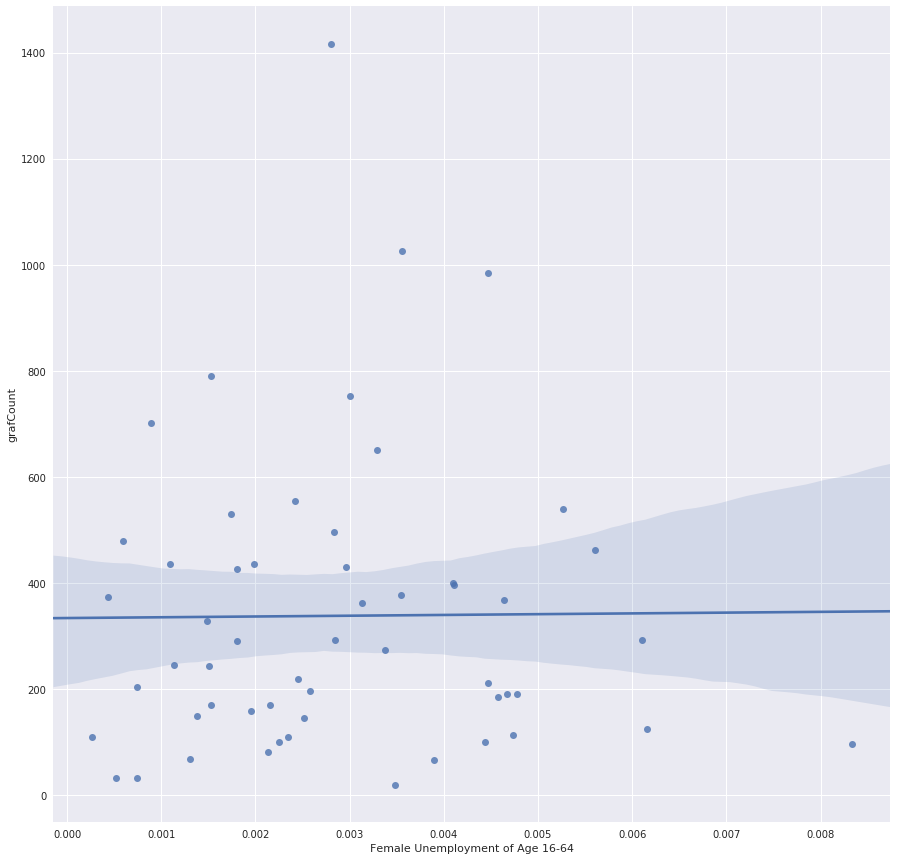

In [302]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)

sns.regplot(x="unemployedF", y="grafCount", data=df_s,ax = ax);

ax.set_ylabel("grafCount")
ax.set_xlabel("Female Unemployment of Age 16-64")
plt.show()

** Figure 5-2: These plots show the ols fit model with grafCount and Female Unemployment, which we didn't see significant positive result .**

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


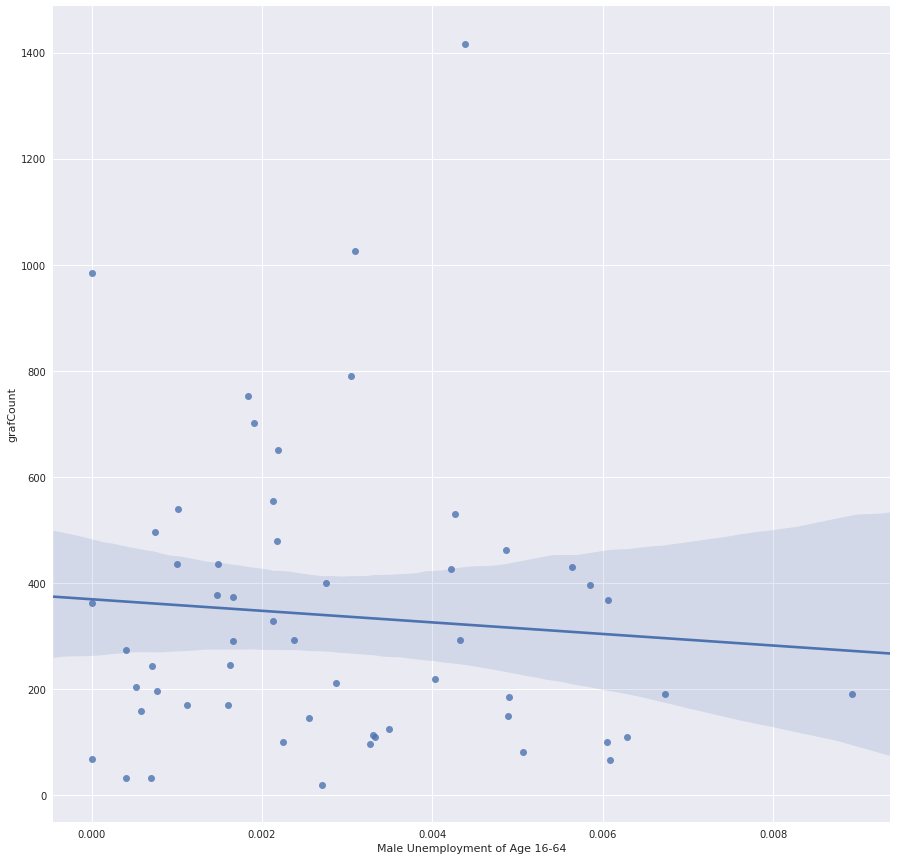

In [303]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)

sns.regplot(x="unemployedM", y="grafCount", data=df_s,ax = ax);

ax.set_ylabel("grafCount")
ax.set_xlabel("Male Unemployment of Age 16-64")
plt.show()

** Figure 5-3: These plots show the ols fit model with grafCount and Male Unemployment, which we didn't see significant negative result .**

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


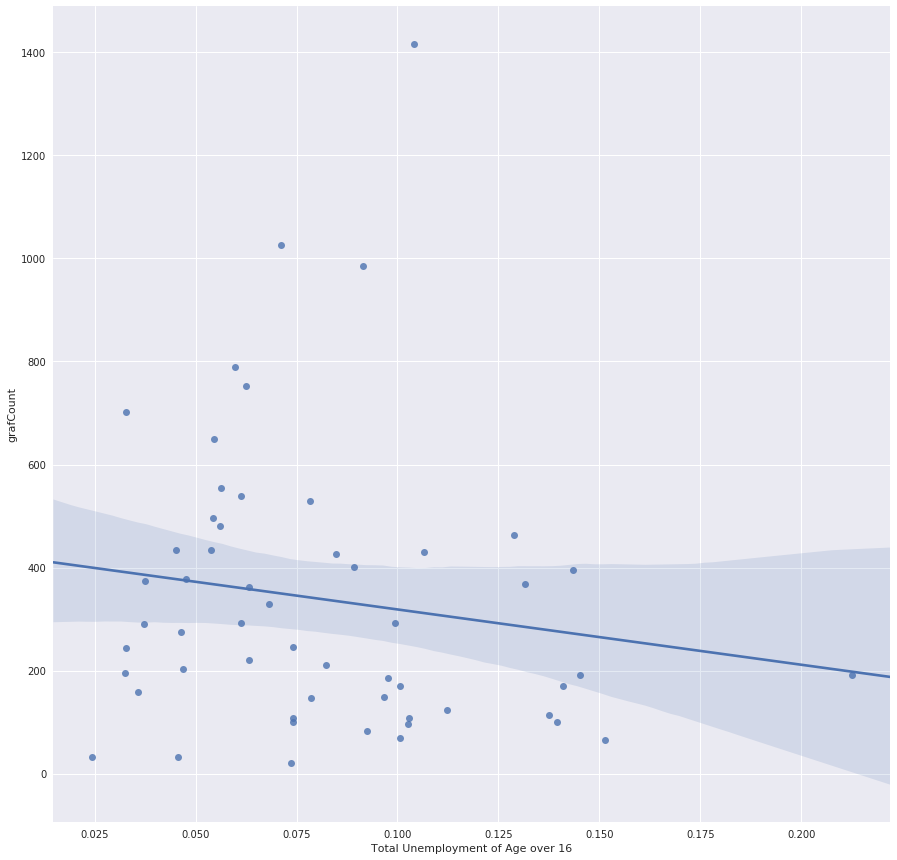

In [305]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)

sns.regplot(x="UnemployedPop", y="grafCount", data=df_s,ax = ax);

ax.set_ylabel("grafCount")
ax.set_xlabel("Total Unemployment of Age over 16")
plt.show()

** Figure 5-4: These plots show the ols fit model with grafCount and total Unemployment of age over 16 , which we didn't see significant negative result .**

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


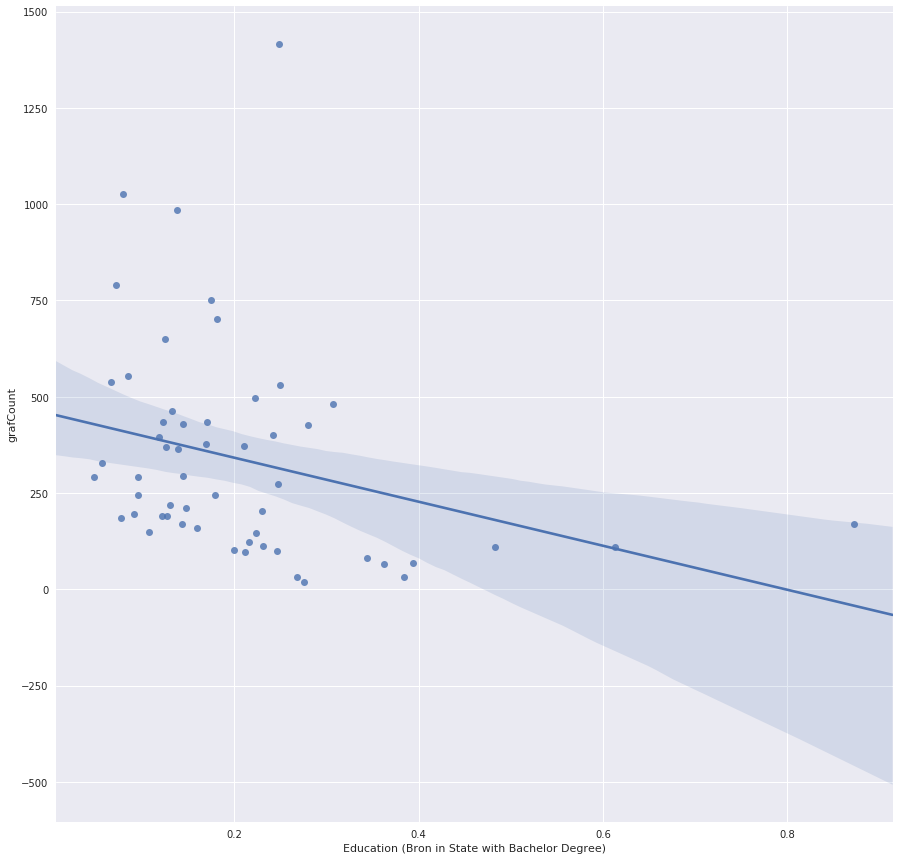

In [306]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)

sns.regplot(x="Edu", y="grafCount", data=df_s,ax = ax);

ax.set_ylabel("grafCount")
ax.set_xlabel("Education (Bron in State with Bachelor Degree)")
plt.show()

**Figure 5-5: These plots show the ols fit model with grafCount and Education level(born in state with a bachler degree) , which I can see week negative correlation result .**

## Conclusion

Based on the analysis above, we cannot see significant correlation between graffiti complaints from 311 and the unemployment rate and crime(relative to Bulgury and theft) in that location, However, the education level have week negative correlation with Graffiti complaints. 

#### Part2

In [307]:
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [308]:
graf.sort_values('year')

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Segment,Latitude,Longitude,Location,startdate,year,month,day,lonlat,geometry
0,15636284,01/01/2010 04:39:20 PM,01/01/2010 04:39:20 PM,DSNY,Department of Sanitation,Graffiti,Graffiti,NaN,11215.0,194 12 STREET,...,NaN,40.668958,-73.991103,"(40.668958142504884, -73.99110341884311)",2010-01-01 16:39:20,2010,1,1,"(-73.9911034188, 40.6689581425)",POINT (-73.99110341884311 40.66895814250488)
14081,18306757,07/20/2010 01:30:29 PM,08/02/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Comercial,11385.0,70-00 71 PLACE,...,NaN,40.706086,-73.880821,"(40.70608568640865, -73.8808210903068)",2010-07-20 13:30:29,2010,7,20,"(-73.8808210903, 40.7060856864)",POINT (-73.8808210903068 40.70608568640865)
14080,18306756,07/20/2010 01:30:28 PM,08/31/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Comercial,11249.0,100 SOUTH 6 STREET,...,NaN,40.710734,-73.964608,"(40.710733931754085, -73.96460779352394)",2010-07-20 13:30:28,2010,7,20,"(-73.9646077935, 40.7107339318)",POINT (-73.96460779352394 40.71073393175409)
14079,18306755,07/20/2010 01:30:27 PM,08/04/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,10023.0,140 WEST 72 STREET,...,NaN,40.777924,-73.980033,"(40.77792362667233, -73.98003298191148)",2010-07-20 13:30:27,2010,7,20,"(-73.9800329819, 40.7779236267)",POINT (-73.98003298191149 40.77792362667233)
14078,18306754,07/20/2010 01:30:25 PM,08/31/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,11249.0,100A BROADWAY,...,NaN,40.710418,-73.965005,"(40.7104184053887, -73.96500473281361)",2010-07-20 13:30:25,2010,7,20,"(-73.9650047328, 40.7104184054)",POINT (-73.96500473281361 40.7104184053887)
14077,18306753,07/20/2010 01:30:24 PM,08/31/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Comercial,11211.0,202 BROADWAY,...,NaN,40.709693,-73.961679,"(40.70969272904603, -73.96167948123664)",2010-07-20 13:30:24,2010,7,20,"(-73.9616794812, 40.709692729)",POINT (-73.96167948123664 40.70969272904603)
14076,18306752,07/20/2010 01:30:23 PM,08/30/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,11211.0,367 SOUTH 5 STREET,...,NaN,40.707922,-73.954095,"(40.707922326730234, -73.95409522814377)",2010-07-20 13:30:23,2010,7,20,"(-73.9540952281, 40.7079223267)",POINT (-73.95409522814377 40.70792232673024)
14075,18306751,07/20/2010 01:30:22 PM,09/23/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,10023.0,260 WEST END AVENUE,...,NaN,40.779700,-73.984542,"(40.77970016400485, -73.98454229933087)",2010-07-20 13:30:22,2010,7,20,"(-73.9845422993, 40.779700164)",POINT (-73.98454229933087 40.77970016400485)
14082,18306758,07/20/2010 01:30:30 PM,11/24/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Comercial,11249.0,50 SOUTH 4 STREET,...,NaN,40.712982,-73.966273,"(40.71298239202725, -73.96627310512139)",2010-07-20 13:30:30,2010,7,20,"(-73.9662731051, 40.712982392)",POINT (-73.96627310512139 40.71298239202725)
14074,18306750,07/20/2010 01:30:21 PM,08/30/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,11211.0,295 MARCY AVENUE,...,NaN,40.704187,-73.954924,"(40.70418702959968, -73.95492372978045)",2010-07-20 13:30:21,2010,7,20,"(-73.9549237298, 40.7041870296)",POINT (-73.95492372978046 40.70418702959968)


In [309]:
# create the duration feature
# 1. 
graf = graf[~graf['Closed Date'].isnull()]
graf = graf.reset_index()

In [310]:
sorted([graf['Closed Date'][i].split(' ')[0].split('/')[-1] for i in range(len(graf['Closed Date']))],reverse = True)

['3027',
 '2201',
 '2201',
 '2201',
 '2201',
 '2100',
 '2047',
 '2047',
 '2023',
 '2019',
 '2019',
 '2019',
 '2019',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 '2018',
 

In [311]:
graf.shape

(125606, 45)

** we see some outliners of the closed date, which is outside the year between 2010-2018 **

In [312]:
graf['closedyear'] = [graf['Closed Date'][i].split(' ')[0].split('/')[-1] for i in range(len(graf['Closed Date']))]
graf['closedyear'] = graf['closedyear'].astype(int)

In [313]:
graf = graf[(graf['closedyear']>2009)&(graf['closedyear']<2019)]
graf['closedate'] = pd.to_datetime(graf['Closed Date'])

In [314]:
graf.shape

(125590, 47)

In [315]:
graf['duration'] = (graf['closedate']-graf['startdate']).dt.days

In [316]:
type(graf['duration'][0])

numpy.int64

In [317]:
sorted(graf['duration'],reverse = True)[-10:] # we found out the negative numbers which we need to filter them out

[-683, -709, -710, -711, -716, -716, -717, -723, -723, -1069]

In [318]:
(graf['duration']>=0).sum()

124893

In [319]:
graf = graf[graf['duration']>=0]
graf.shape

(124893, 48)

In [320]:
graf.head()

,index,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,...,Location,startdate,year,month,day,lonlat,geometry,closedyear,closedate,duration
0,0,15636284,01/01/2010 04:39:20 PM,01/01/2010 04:39:20 PM,DSNY,Department of Sanitation,Graffiti,Graffiti,NaN,11215.0,...,"(40.668958142504884, -73.99110341884311)",2010-01-01 16:39:20,2010,1,1,"(-73.9911034188, 40.6689581425)",POINT (-73.99110341884311 40.66895814250488),2010,2010-01-01 16:39:20,0
1,1,15636303,01/01/2010 05:26:37 PM,06/30/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,10033.0,...,"(40.84444801315609, -73.93621512605705)",2010-01-01 17:26:37,2010,1,1,"(-73.9362151261, 40.8444480132)",POINT (-73.93621512605705 40.8444480131561),2010,2010-06-30 00:00:00,179
2,2,15636304,01/01/2010 05:37:18 PM,01/26/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,10467.0,...,"(40.87648037643658, -73.8746649374504)",2010-01-01 17:37:18,2010,1,1,"(-73.8746649375, 40.8764803764)",POINT (-73.8746649374504 40.87648037643658),2010,2010-01-26 00:00:00,24
3,3,15636305,01/01/2010 05:59:13 PM,07/28/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,10032.0,...,"(40.839364876845416, -73.94151452115523)",2010-01-01 17:59:13,2010,1,1,"(-73.9415145212, 40.8393648768)",POINT (-73.94151452115523 40.83936487684542),2010,2010-07-28 00:00:00,207
4,4,15636306,01/01/2010 06:00:09 PM,06/30/2010 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,10032.0,...,"(40.839364876845416, -73.94151452115523)",2010-01-01 18:00:09,2010,1,1,"(-73.9415145212, 40.8393648768)",POINT (-73.94151452115523 40.83936487684542),2010,2010-06-30 00:00:00,179


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


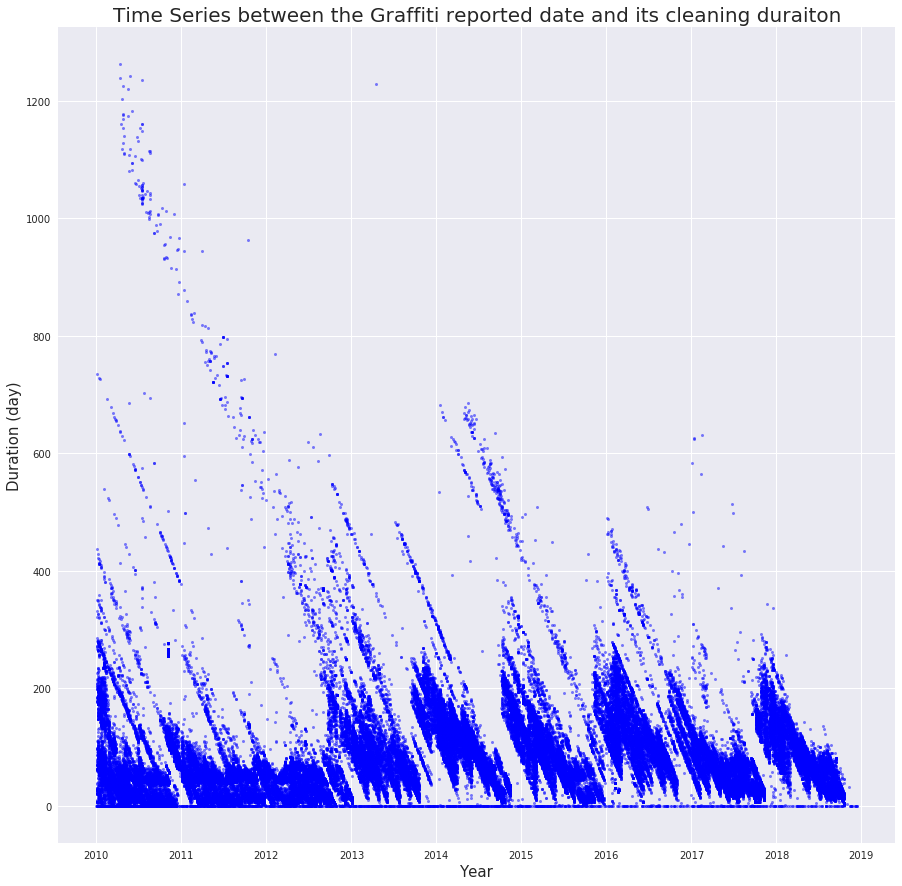

In [321]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
ax.plot(graf['startdate'],graf['duration'],'bo',markersize=3,alpha = 0.5)
ax.set_xlabel('Year',fontsize = 15)
ax.set_ylabel('Duration (day)',fontsize = 15)
ax.set_title('Time Series between the Graffiti reported date and its cleaning duraiton',fontsize = 20)
plt.show()

**Figure 6: This scatter plot show the time series between the 311 graffiti complaints create between (2010 -2018) and their cleaning duration time. we can see a clear visual trend  .**

In [322]:
graf.crs = from_epsg(4326)
graf.to_crs(epsg=2263,inplace = True)

In [323]:
graf.crs

{'init': 'epsg:2263', 'no_defs': True}

In [324]:
# fig = plt.figure(figsize = (15,15))
# ax = fig.add_subplot(111)
# pumadata.plot(ax=ax,color = 'white',edgecolor = 'black',lw = 1)
# graf[graf['duration']>60].plot(ax=ax,column = 'duration',cmap = 'autumn',markersize = graf['duration']/10,alpha=0.1)


In [325]:
graf['weeknum'] = graf['startdate'].dt.week

In [326]:
# I need to divide the dataframe from 2010 to 2017 (without 2018 because year2018 is not complete yet)
grafAll = [graf[graf['year']==i] for i in range(2010,2018)]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


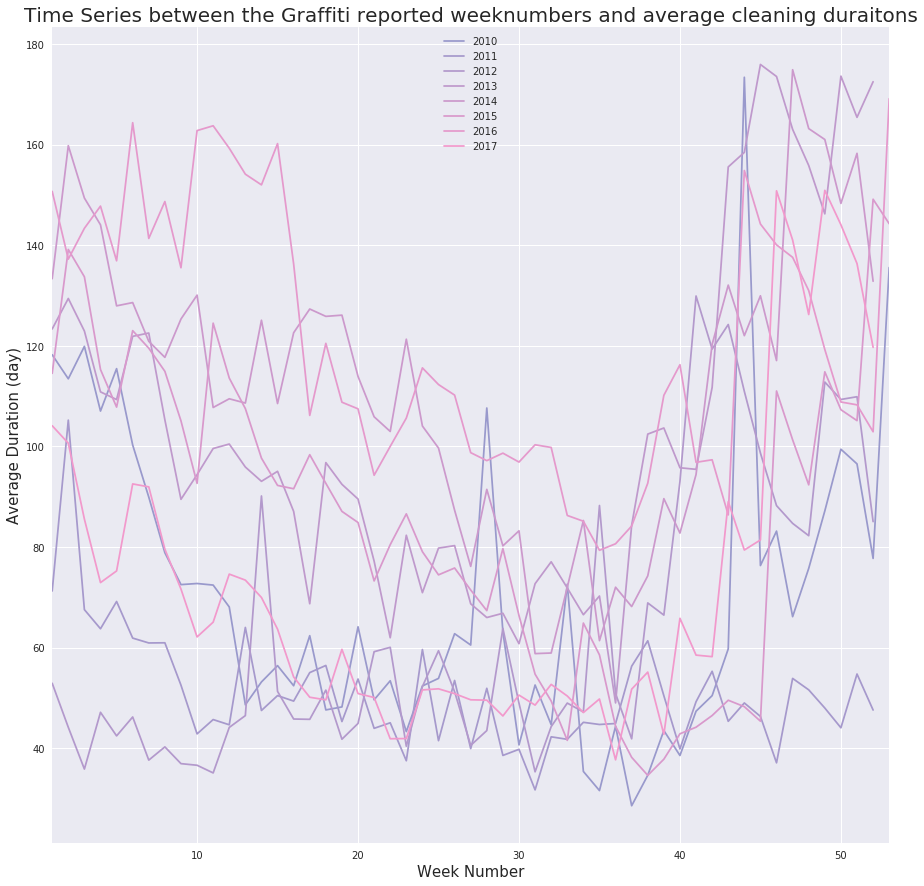

In [327]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
for i in range(len(grafAll)):
    grafAll[i][['weeknum','duration']].groupby('weeknum')['duration'].mean().plot(ax = ax,label = str(2010+i),color = (i/20+0.6,0.6, 0.8, 1))
ax.set_xlabel('Week Number',fontsize = 15)
ax.set_ylabel('Average Duration (day)',fontsize = 15)
ax.set_title('Time Series between the Graffiti reported weeknumbers and average cleaning duraitons',fontsize = 20)
ax.legend()
plt.show()
  

**Figure 7: 'Time Series between the Graffiti reported weeknumber and its average cleaning duraiton for each year(2010-2017). we can see a clear visual trend and it looks like there are difference between of the start and end of the year.**

In [328]:
graf_ts = pd.DataFrame(graf[['duration','weeknum']].groupby('weeknum',as_index = False)['duration'].mean())

In [329]:
graf_ts.index = graf_ts.weeknum

In [330]:
graf_ts.drop('weeknum',axis = 1,inplace = True);graf_ts.head()

,duration
weeknum,
1,111.266003
2,121.525330
3,116.897378
4,111.005618
5,108.266055


In [331]:
# Timeseries and AR model (from my ADS homework4)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


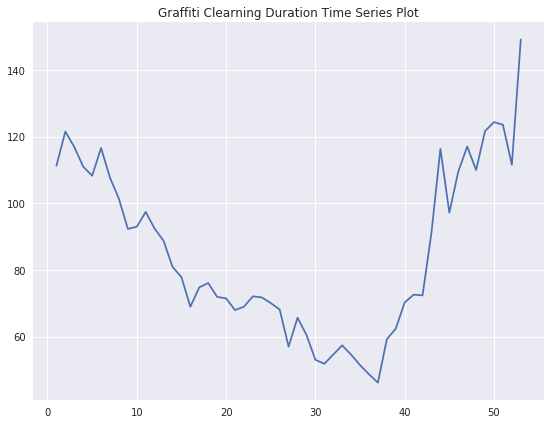

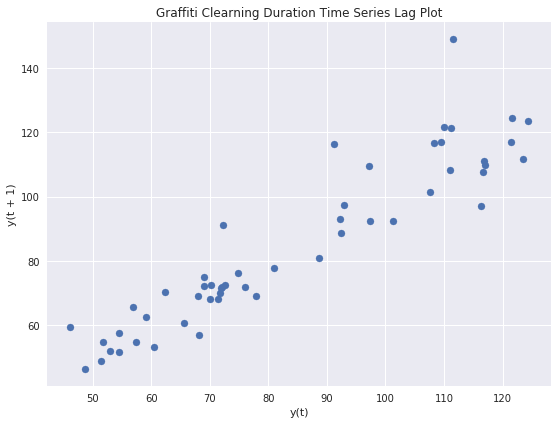

In [332]:
duration_ts= graf_ts[['duration']]
duration_ts.name = 'Graffiti Clearning Duration Time Series'

def time_series_plotting(func, series):
    """
    takes time series data and plots, based on a give function
    """
    fig, ax = plt.subplots(2, figsize=(15,6))

    plt.subplot(121)

    func(series)
    plt.title('{} {}'.format(series.name, func.__name__).replace('_', ' ').title())



    plt.tight_layout()
    plt.show()

time_series_plotting(plt.plot, duration_ts)
time_series_plotting(lag_plot, duration_ts)

**Figure 8: 1. Time Series between the Graffiti reported weeknumber and its average cleaning duraiton for the 7 years (2010-2017). we can see in summer it usually take shorter time to clean the graffiti and the winter it take longer more than 3months  2. the lag plot show there are significant positive correlation for the timeseries about weeks number and cleaning duraion.
**

trainset length is 46

Graffiti Clearning Duration Time Series
Lag: 10
Test_Active MSE: 279.112



/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


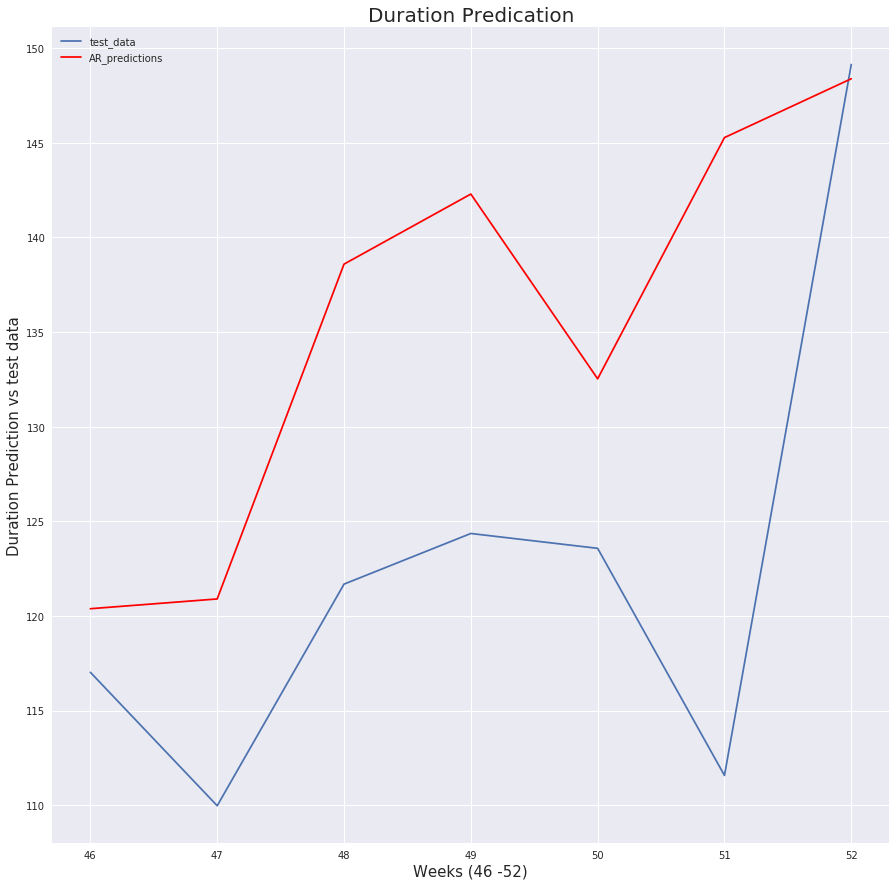

In [333]:
from statsmodels.tsa.ar_model import AR
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AR.html
from sklearn.metrics import mean_squared_error
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
# https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/ For the bese MSE

d = 7
def fit_AR1(series):
    # split into train and test sets
    vals = series.values

    print('trainset length is {}'.format(len(vals)-d))
    print()
    train, test = vals[0:len(vals)-d], vals[len(vals)-d:]



    model = AR(train)
    model_fit = model.fit()
    print(series.name)
    
    # walk-forward validataion
    print('Lag: %s' % model_fit.k_ar)
    predictions = model_fit.predict(start = len(train),end = len(vals)-1,dynamic = False)
    for i in range(len(predictions)):
        #print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        error = mean_squared_error(test,predictions)
    print('Test_Active MSE: %.3f' % error)
    return test, predictions

t1, p1 = fit_AR1(duration_ts)
print()


fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)

xticks = range(len(duration_ts)-d,len(duration_ts))
ax.plot(xticks,t1, label='test_data')
ax.plot(xticks,p1, color='red', label='AR_predictions')

plt.xticks(xticks)
ax.set_xlabel('Weeks (46 -52)',fontsize = 15)
ax.set_ylabel('Duration Prediction vs test data',fontsize = 15)
plt.title('Duration Predication',fontsize = 20)
plt.legend()


plt.show()

**Figure 9: I use the Autoregressive Model AR(1) to predict the duraion by week number. I split the weeknumber of first 46 as training and the last6 week as testing, I got the Mean Square Error is around 256, such .**

In [334]:
duration_ts.head()

,duration
weeknum,
1,111.266003
2,121.525330
3,116.897378
4,111.005618
5,108.266055


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


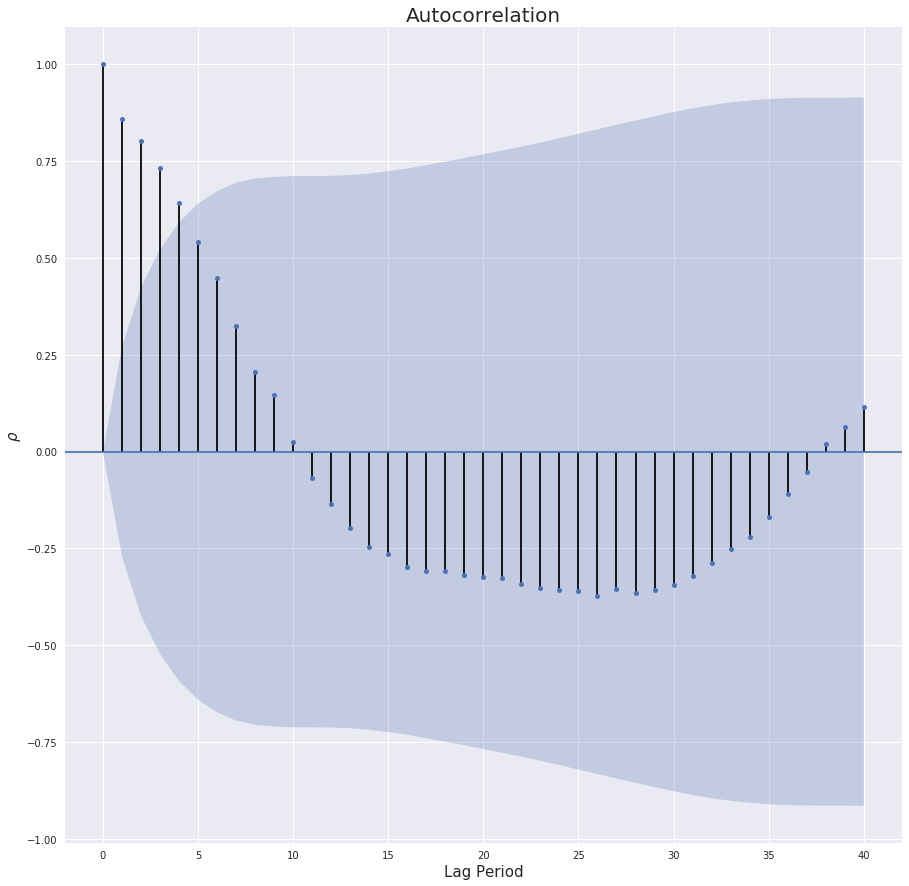

In [335]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
import statsmodels.api as sma

sma.graphics.tsa.plot_acf(duration_ts['duration'].squeeze(), lags=40,ax = ax)
ax.set_xlabel('Lag Period',fontsize = 15)
ax.set_ylabel(r'$\rho$',fontsize = 15)
plt.title('Autocorrelation',fontsize = 20)
plt.legend()

**Figure 10: I run a autocorrelation plot with lag value along the x-axis and the correlation on the y-axis between -1 and 1. The Blue Cone area is the confidence intervals. It is by default the set to a 95% confidence interval. Now we can see at the lag of 5 we can see the model fall into the confidence interval.**